In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from yaml import dump
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import timm

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets

fig.initialize('sae')
from omnifig.projects import sae
import networkx as nx

# from src import sample_full_interventions, response_mat, factor_reponses
dataset = None
src = None

In [2]:
device = 'cuda'
figure_dir = Path('../learn_rep/figures/responses')
figure_dir = None
figure_root = None
seed = 10
torch.manual_seed(seed)

src = None

num_nodes = 5

B = 48
N = num_nodes + 3
G = 32
C = 3
H, W = 100, 100
# H, W = 64, 64

In [3]:
# dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)
# len(dataset)

In [4]:
# dataset = fig.quick_run('load-data', 'extra/angle-shape')
# len(dataset), dataset._modes.keys()

In [5]:
# dataset.switch_to('extra')
# len(dataset)

In [6]:
# batch = dataset.get_batch(batch_size=64)
# X, = batch
# X.shape

In [7]:
# util.plot_imgs(X);

In [8]:
root = Path(r'C:\Users\anwan\Documents\workspace\exts')
# root = Path(r'C:\Users\anwan\Documents\workspace\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

30

In [9]:
print(tabulate(enumerate(run_names)))

--  -----------------------------------------------
 0  3ds_ae_e-c12_d-c12_xas_210424-022530
 1  3ds_ae_e-c12_d-c12_xa_210424-022637
 2  3ds_ae_e-c12_d-s12_xa-s2_210424-022635
 3  3ds_ae_e-c12_d-s12_xas-s2_210424-022530
 4  3ds_ae_e-c12_d-s12_xas_210424-022530
 5  3ds_ae_e-c12_d-s12_xa_210424-022637
 6  3ds_vae1_e-c12_d-c12_xas_210424-022530
 7  3ds_vae1_e-c12_d-c12_xa_210424-022638
 8  3ds_vae2_e-c12_d-c12_xas_210424-022528
 9  3ds_vae2_e-c12_d-c12_xa_210424-022637
10  3ds_wae10_e-c12_d-c12_xas_210424-022529
11  3ds_wae10_e-c12_d-c12_xa_210424-022636
12  cppn_ae_e-c12_d-c12_210424-021457
13  cppn_ae_e-c12_d-s12_210424-021456
14  cppn_ae_e-c12_d-s12_210424-021457
15  cppn_ae_e-c12_d-s12_n6_210424-022637
16  cppn_ae_e-c12_d-s12_scm-n6_210424-022639
17  cppn_ae_e-c12_d-s12_scm-nlin-n6_210424-022638
18  cppn_vae1_e-c12_d-c12_210424-021458
19  cppn_vae1_e-c12_d-c12_n6_210424-022636
20  cppn_vae1_e-c12_d-c12_scm-n6_210424-022637
21  cppn_vae1_e-c12_d-c12_scm-nlin-n6_210424-022637
22  cppn_v

In [26]:
run_name = run_names[8]
run_name = run_names[9]

run_name

'3ds_vae2_e-c12_d-c12_xa_210424-022637'

In [27]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)

In [38]:
run.get_path()

WindowsPath('C:/Users/anwan/Documents/workspace/exts/3ds_vae2_e-c12_d-c12_xa_210424-022637')

In [28]:
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'arch_type': 'c12',
 'dataset_type': '3ds',
 'dec_type': 'c12',
 'enc_type': 'c12',
 'extra': 'xa',
 'model_type': 'vae',
 'size': 64}

In [29]:
if figure_root is not None:
    figure_dir = figure_root / run_name
    if not figure_dir.exists():
        figure_dir.mkdir()
else:
    figure_dir = None
model = run.get_model()
model.switch_to('val')
model.to(device);

Freezable_Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [30]:
dataset = run.get_dataset()
len(dataset)

253556

In [31]:
dataset.switch_to('extra')
len(dataset)

102271

In [32]:
X, = dataset.get_batch(batch_size=64)
X.shape

torch.Size([64, 3, 64, 64])

<IPython.core.display.Javascript object>


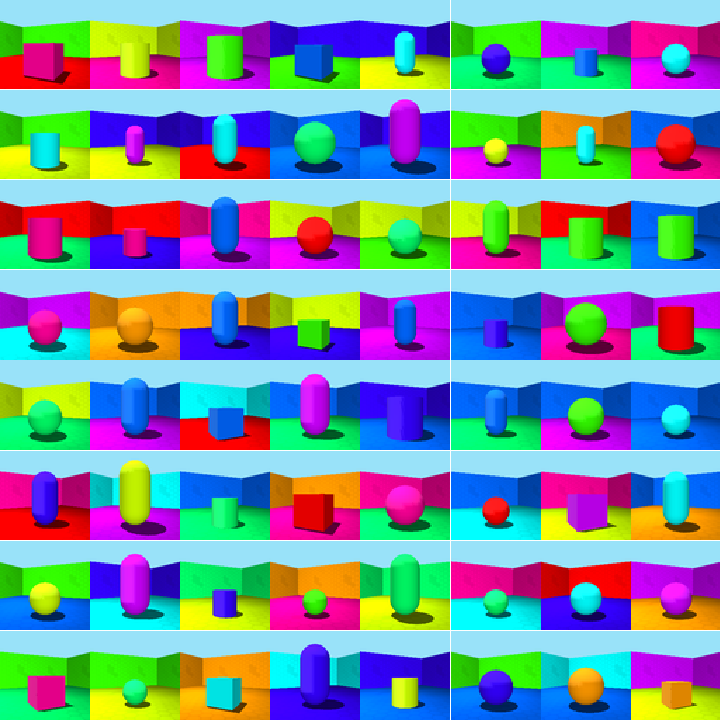

In [33]:
util.plot_imgs(X);

In [34]:
with torch.no_grad():
    R, Q = model(X, ret_q=True)
    if isinstance(Q, distrib.Distribution):
        Q = Q.mean
R.shape, Q.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 12]))

<IPython.core.display.Javascript object>


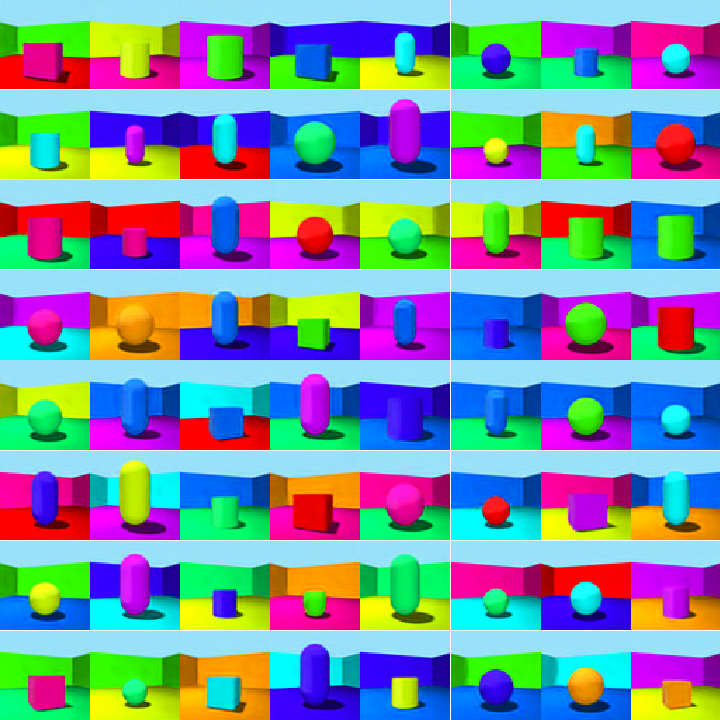

In [35]:
util.plot_imgs(R);